# Studying the content of the YADL variants

This notebook is used to produce some statistics on the tables stored in YADL and evaluate the main differences between
YADL variants. 

In [3]:
cd ..

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [4]:
import polars as pl
import pandas as pd
import json
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
metadata_dir = Path("data/metadata")

Iterating over all tables in each YADL variant, then saving both the aggregate and complete results in dataframes. 

In [6]:
avg_df = []
all_stats = []
variants = ["wordnet_big", "binary"]
# variants = ["binary"]
for variant in variants:
    print(variant)
    total_files = sum([1 for _ in Path(metadata_dir, variant).glob("**/*.json")])
    mdata_files = Path(metadata_dir, variant).glob("**/*.json")
    total_size = 0
    list_dicts = []
    for f in tqdm(mdata_files, total=total_files):
        with open(f, "r") as fp:
            mdata = json.load(fp)
            table_path = Path(mdata["full_path"])
            file_size = table_path.stat().st_size
            total_size += file_size
            
            table = pl.read_parquet(table_path)
            if table.shape[0] == 1:
                print(table_path)
                continue
            subj_avg = table.groupby("subject").count().mean()["count"].item()
            subj_median = table.groupby("subject").count().median()["count"].item()
            cat_feat = 0
            num_feat = 0
            for col, typ in table.schema.items():
                if typ == pl.Utf8:
                    cat_feat += 1
                else:
                    num_feat += 1

            dd = {
                "variant": variant,
                "table_name": table_path.stem,
                "num_rows": table.shape[0],
                "num_cols": table.shape[1],
                "file_size": file_size,
                "subj_avg": subj_avg,
                "subj_median": subj_median,
                "cat_feat": cat_feat,
                "num_feat": num_feat,
            }
            list_dicts.append(dd)

    df_stat = pl.from_dicts(list_dicts)
    avg_stats = df_stat.select(
        pl.lit(variant).alias("Variant"),
        pl.col("num_rows").mean().alias("avg_num_rows"),
        pl.col("num_rows").median().alias("median_num_rows"),
        pl.col("num_rows").max().alias("max_num_rows"),
        pl.col("num_rows").min().alias("min_num_rows"),
        pl.col("num_cols").max().alias("max_num_cols"), 
        pl.col("num_cols").min().alias("min_num_cols"), 
        pl.col("file_size").mean().alias("avg_file_size")/1e6,
        pl.col("table_name").count().alias("num_tables"),
        pl.lit(total_size).alias("total_size")/1e6,
        pl.col("subj_avg").mean(),
        pl.col("subj_median").mean(),
    )   
    avg_df.append(avg_stats)
    all_stats.append(df_stat)
all_stat_variants = pl.concat(all_stats)

wordnet_big


100%|██████████| 4080/4080 [00:27<00:00, 148.92it/s]


binary


100%|██████████| 67/67 [00:08<00:00,  7.76it/s]

/storage/store/work/rcappuzz/yago3-dl/binary/yago_binary_startedOnDate.parquet
/storage/store/work/rcappuzz/yago3-dl/binary/yago_binary_hasNeighbor.parquet


Printing the most frequenty types. 

In [7]:
largest_wordnet=all_stat_variants.filter(pl.col("variant")=="wordnet_big").sort("num_rows", descending=True).limit(10).select("table_name").to_series().to_list()
largest_binary=all_stat_variants.filter(pl.col("variant")=="binary").sort("num_rows", descending=True).limit(10).select("table_name").to_series().to_list()

print(f"{'Rank':<10}", f"{'Binary':<40}", 'Wordnet')
for idx in range(10):
    print(f"{idx+1:<10}", f"{largest_binary[idx]:<40}", largest_wordnet[idx])

Rank       Binary                                   Wordnet
1          yago_binary_isCitizenOf                  yagowordnet_wordnet_person
2          yago_binary_hasGender                    person_playsFor_isAffiliatedTo
3          yago_binary_isLocatedIn                  person_wasBornOnDate_playsFor_isAffiliatedTo
4          yago_binary_wasBornOnDate                person_playsFor_isAffiliatedTo_hasHeight
5          yago_binary_isAffiliatedTo               yagowordnet_wordnet_company
6          yago_binary_wasBornIn                    yagowordnet_wordnet_artist
7          yago_binary_playsFor                     person_wasBornOnDate_isAffiliatedTo
8          yago_binary_diedOnDate                   person_wasBornOnDate_playsFor
9          yago_binary_created                      artist_created_wroteMusicFor
10         yago_binary_wasCreatedOnDate             artist_created_hasMusicalRole_wroteMusicFor


Plotting some of the aggregated statistics gathered in the previous step. 

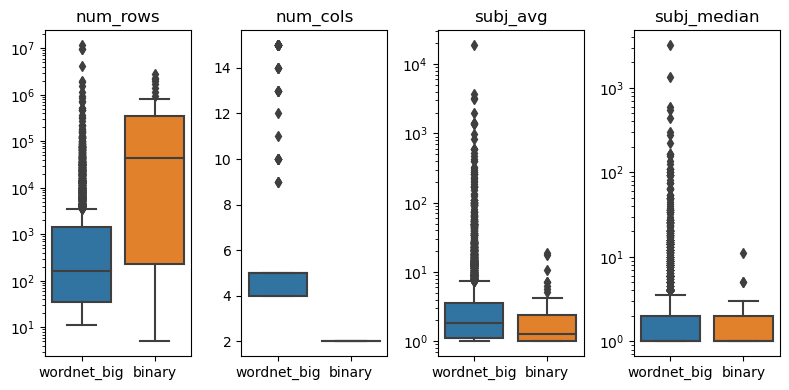

In [8]:
variables_of_interest = ["num_rows", "num_cols", "subj_avg", "subj_median"]
df_melt=all_stat_variants.melt(
    id_vars=["variant"],
    value_vars=variables_of_interest
)

fig, axs = plt.subplots(1, len(variables_of_interest), figsize=(8,4))
for idx, var in enumerate(variables_of_interest):
    ax = axs[idx]
    ax=sns.boxplot(data=df_melt.filter(pl.col("variable")==var).to_pandas(), x="variant", y="value", ax=ax)
    if var != "num_cols":
        ax.set_yscale("log")
    ax.set_title(var)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    # ax.get_legend().remove()

plt.tight_layout() 

Preparing the aggregated stats

In [9]:
stat_variants = pl.concat(avg_df)

In [10]:
stat_variants.select(
    pl.col("Variant"),
    pl.col("num_tables").alias("# Tables"),
    pl.col("avg_num_rows").alias("Avg. rows"),
    pl.col("median_num_rows").alias("Med. rows"),
    pl.col("avg_file_size").alias("Avg. size"),
    pl.col("total_size").alias("Total size"),
)

Variant,# Tables,Avg. rows,Med. rows,Avg. size,Total size
str,u32,f64,f64,f64,f64
"""wordnet_big""",4080,16031.73848,164.0,0.135622,553.339654
"""binary""",65,322672.030769,44340.0,4.520355,293.824463


In [11]:
spd = stat_variants.drop(["Total size", "Max. # rows", 	"Max. # columns"]).to_pandas()

SchemaFieldNotFoundError: Total size

In [ ]:
spd.style.format(precision=2, subset=["Avg. file size (MB)", "Total size (MB)"]).format(subset=["Avg. # rows"], precision=0).to_latex("tab.tex", hrules=True)

In [ ]:
spd.style.to_latex("tab.tex", hrules=True)

# Base table stats

In [ ]:
data_dir = Path("data/metadata/queries")
tabs_mdata_paths = list(data_dir.glob("*.json"))

In [ ]:
stats_list = []
for tab_mdata_pth in tabs_mdata_paths:
    with open(tab_mdata_pth, "r") as fp:
        tab_mdata = json.load(fp)
        tab_path = tab_mdata["full_path"]
        tab = pl.read_parquet(tab_path).unique()
        cat_feat = 0
        num_feat = 0
        for col, typ in tab.schema.items():
            if typ == pl.Utf8:
                cat_feat += 1
            else:
                num_feat += 1
        stats = {
            "tab_name": tab_mdata["df_name"],
            # "tab_source": "add",
            "num_rows": tab.shape[0],
            # "num_cols": tab.shape[1],
            "cat_feat": cat_feat,
            "num_feat": num_feat,
            # "target": "add"
        }
        stats_list.append(stats)

In [ ]:
base_table_stats = pl.from_dicts(stats_list)
base_table_stats = base_table_stats.select(
    pl.col("tab_name").alias("Table name"),
    pl.col("num_rows").alias("Rows"),
    pl.col("cat_feat").alias("$C$"),
    pl.col("num_feat").alias("$N$"),
)

In [ ]:
base_table_stats.to_pandas().style.to_latex("base_tables.tex", hrules=True)

In [ ]:
base_table_stats

Table name,Rows,$C$,$N$
str,i64,i64,i64
"""presidential-r…",22084,12,1
"""company-employ…",3107,8,2
"""movies-prepare…",3826,14,5
"""us-accidents-p…",20000,23,28
"""us-accidents-p…",5222,10,3
"""presidential-r…",21289,6,1
